# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline for U-Net using ultrasound data.  

In [25]:
import os       # file access
import matplotlib.pyplot as plt     # plotting of the results (possibly later)

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm   # for epoch iteration
from glob import glob   # for dataset preprocessing
from sklearn.model_selection import train_test_split # to perform validation on simulation data
import scipy.io as sio
import numpy as np
import random 
############################################################################################################################
# user defined models
from models.resnet import CustomResNet      # custom resnet architecture - CNN baseline
from models.unet   import CustomUNet        # custom unet architecture - better CNN baseline
from models.effunet import EfficientUNetBeamformer  # efficientnet encoder + unet decoder - final model

# user defined scripts
from dataloader.load_rf import load_rf_stack
from dataloader.load_rf import group_plane_waves
from dataloader.load_gt import load_gt_stack
from dataloader.dataset import UltrasoundDataset                # custom class to handle ultrasound RF and image data

from utils.visualize_raw import visualize_gt_db
from utils.visualize_raw import visualize_rf_line

from utils.losses import ssim_loss, mae_loss, combined_loss     # loss functions possibly interesting for US data
from utils.metrics import compute_metrics                       # function to compute SSIM and PSNR for comparisons later


## Configuration
Define all the training parameters in one variable.

In [26]:
TARGET_DEPTH = 1600 # target number of samples for all considered RF files
DATASET_SIZE = 300  # number of total samples loaded in the notebook
BATCH_SIZE = 4
PW_PER_IMG = 5 # number of plane waves we want to use to reconstruct one GT image

In [27]:
CONFIG = {
    'model_name': 'unet',           # options: 'resnet', 'unet', 'effunet'
    'loss_function': 'ssim',          # options: 'ssim', 'mae', 'combined'
    'batch_size': BATCH_SIZE,
    'lr': 1e-4,
    'epochs': 100,
    'input_size': None,               # we set it based on the max depth of processed .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'data_dir_rf': os.path.join('..', 'data', 'raw'),
    'data_dir_img': os.path.join('..', 'data', 'processed'),
    'checkpoints_dir': None, # will be set below
}

# Set checkpoint path
CONFIG['checkpoints_dir'] = os.path.join('..', 'checkpoints', CONFIG['model_name'])

# (Optional) Create the directory if it doesn't exist
os.makedirs(CONFIG['checkpoints_dir'], exist_ok=True)


In [28]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA is available! Using GPU: {device_name}")
else:
    print("❌ CUDA is not available. Training will be **very slow** on CPU.")


❌ CUDA is not available. Training will be **very slow** on CPU.


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

In [29]:
# test rf loading
rf_paths  = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
rf_tensor = load_rf_stack(rf_paths, target_depth=TARGET_DEPTH)  # Output: [300, TARGET_DEPTH, 128]

if PW_PER_IMG != 1:
    rf_tensor = group_plane_waves(rf_tensor, PW_PER_IMG)  # shape: [60, 5, 1600, 128]

print(f"We are using {PW_PER_IMG} waves per reconstructed image!")
print("RF tensor shape:", rf_tensor.shape)


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

We are using 5 waves per reconstructed image!
RF tensor shape: torch.Size([60, 5, 1600, 128])


In [ ]:
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))
gt_tensor = load_gt_stack(img_paths, repeats_per_img=75//PW_PER_IMG, downsample_factor=1)  # [300, 387, 609]

print(f"We are using {PW_PER_IMG} waves per reconstructed image!")
print("GT tensor shape:", gt_tensor.shape)   # should be [450, 387, 609]

[INFO] Global max (linear magnitude): 907.6446


100%|██████████| 4/4 [00:00<00:00, 49.16it/s]

We are using 5 waves per reconstructed image!
GT tensor shape: torch.Size([60, 387, 609])


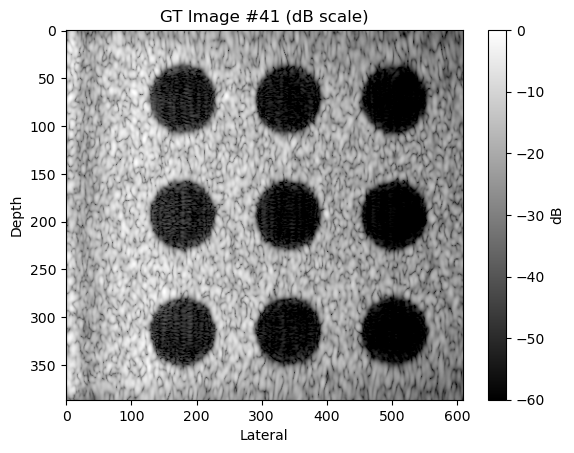

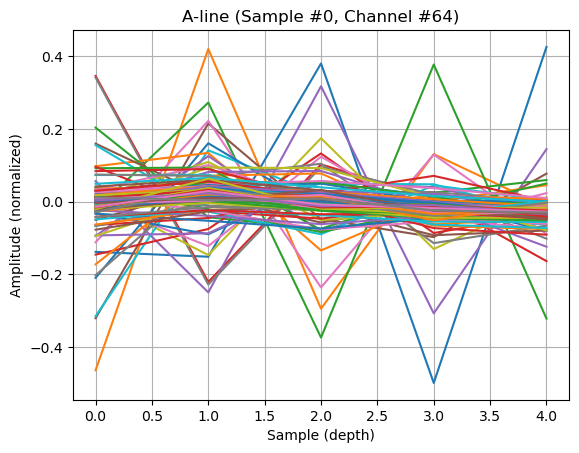

In [ ]:
# visualize random image from the ones read
visualize_gt_db(gt_tensor, idx=random.randint(0, gt_tensor.shape[0] - 1))
visualize_rf_line(rf_tensor, file_idx=0, pw_idx=10, ch_idx=64) # doesn't work for multiple plane waves

## Data Augmentation
In this part we create new tensors with augmented GT images and zeroes out transducer channels. Output of this section should be DataLoader.

In [37]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (val + test)
rf_train, rf_temp, gt_train, gt_temp = train_test_split(
    rf_tensor, gt_tensor, test_size=0.2, random_state=42, shuffle=True
)

# Second split: 50% val, 50% test from the remaining 20%
rf_val, rf_test, gt_val, gt_test = train_test_split(
    rf_temp, gt_temp, test_size=0.5, random_state=42, shuffle=True
)

Original shape: torch.Size([48, 387, 609])
Augmented shape: torch.Size([48, 387, 609])
Visualizing index: 39


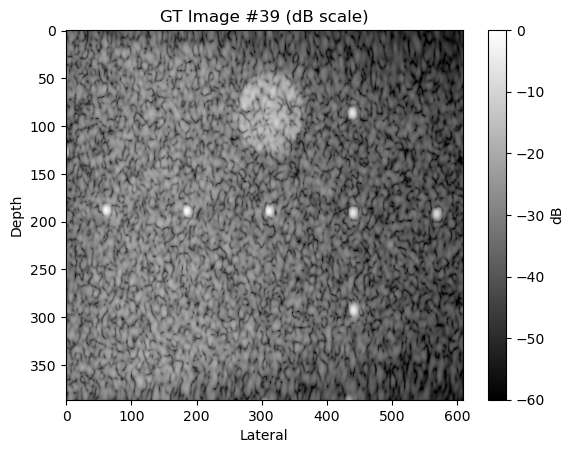

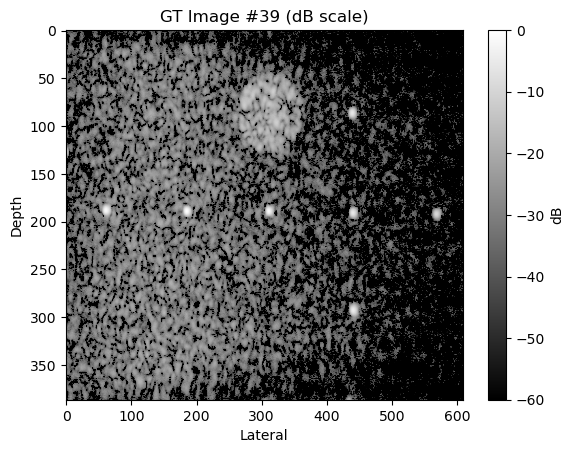

In [38]:
def augment_gt_tensor(gt_tensor, contrast_factor=1.001, noise_std=0.0005, prob=1):
    """
    Apply random augmentation (contrast + noise) to each GT image in a tensor.
    Values are clamped to [0, 1] instead of normalized.

    Args:
        gt_tensor (torch.Tensor): [N, H, W] GT images.
        contrast_factor (float): How much to jitter contrast.
        noise_std (float): Standard deviation of Gaussian noise.
        prob (float): Probability to apply augmentation per image.

    Returns:
        torch.Tensor: Augmented GT tensor [N, H, W]
    """
    augmented = []

    for i in range(gt_tensor.shape[0]):
        img = gt_tensor[i].clone()

        if torch.rand(1).item() < prob:
            # Contrast jitter
            img = (img - 0.5) * contrast_factor + 0.5

            # Gaussian noise
            noise = torch.randn_like(img) * noise_std
            img = img + noise

            # Clamp to [0, 1]
            img = torch.clamp(img, 0.0, 1.0)

        augmented.append(img)

    return torch.stack(augmented)



# ==== Test it on gt_train ====
gt_augmented = augment_gt_tensor(gt_train)

print("Original shape:", gt_train.shape)
print("Augmented shape:", gt_augmented.shape)

# Visual check with a random index
idx_test1 = torch.randint(0, gt_train.shape[0], (1,)).item()
print(f"Visualizing index: {idx_test1}")

visualize_gt_db(gt_train, idx=idx_test1)
visualize_gt_db(gt_augmented, idx=idx_test1)


In [39]:
# we need a function to randomly zero out transducer elements [450 x 10% zeroed out x 3000 something]
import torch
import numpy as np
import random

def zero_out_rf_channels(rf_tensor, dropout_rate=0.1):
    """
    Randomly zero out dropout_rate fraction of transducer channels.

    Args:
        rf_tensor (torch.Tensor): [N, D, C] RF data
        dropout_rate (float): Fraction of channels to zero out

    Returns:
        rf_aug (torch.Tensor): Augmented tensor with dropped channels
        dropped_channels (list[int]): Indices of zeroed channels
    """
    N, D, C = rf_tensor.shape
    num_drop = int(C * dropout_rate)
    dropped_channels = sorted(random.sample(range(C), num_drop))

    # Clone to avoid modifying original
    rf_aug = rf_tensor.clone()
    rf_aug[:, :, dropped_channels] = 0

    return rf_aug, dropped_channels

# ==== Test it on rf_train ====
rf_augmented, zeroed_idx = zero_out_rf_channels(rf_train, dropout_rate=0.1)

print("RF original shape: ", rf_train.shape)
print("RF augmented shape:", rf_augmented.shape)
print("Dropped channel indices:", zeroed_idx)

# Choose a random sample index from rf_train
file_idx = torch.randint(0, rf_train.shape[0], (1,)).item()
pw_idx = 8
ch_idx = zeroed_idx[0]

print(f"Visualizing file index: {file_idx}, PW: {pw_idx}, Channel: {ch_idx}")

# Visualize original
print("Original RF slice:")
visualize_rf_line(rf_train, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)

# Visualize zeroed
print("Augmented RF slice:")
visualize_rf_line(rf_augmented, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)


ValueError: too many values to unpack (expected 3)

In [ ]:
from torch.utils.data import TensorDataset

# === 1. Augment GT for training ===
gt_train_augmented = augment_gt_tensor(gt_train)  # Shape: [N, 387, 609]
print("Augmented GT shape:", gt_train_augmented.shape)

# === 2. Zero out 10% of channels in RF training data ===
#rf_train_subsampled, dropped_channels = zero_out_rf_channels(rf_train, dropout_rate=0.1)
#print("Dropped channels (for sanity check):", dropped_channels)

# === 4. Create TensorDatasets ===
train_clean_ds = TensorDataset(rf_train, gt_train.unsqueeze(1))  # Clean inputs
#train_noisy_ds = TensorDataset(rf_train_subsampled_grouped, gt_train_augmented.unsqueeze(1))  # Noisy inputs
val_ds         = TensorDataset(rf_val, gt_val.unsqueeze(1))  # Single PW
test_ds        = TensorDataset(rf_test, gt_test.unsqueeze(1))  # Single PW

# === 5. Print sample shapes to verify ===
print("Train Clean:", train_clean_ds[0][0].shape, train_clean_ds[0][1].shape)   # [5, 1600, 128], [1, 387, 609]
#print("Train Noisy:", train_noisy_ds[0][0].shape, train_noisy_ds[0][1].shape)   # [5, 1600, 128], [1, 387, 609]
print("Val:", val_ds[0][0].shape, val_ds[0][1].shape)                           # [1, 1600, 128], [1, 387, 609]
print("Test:", test_ds[0][0].shape, test_ds[0][1].shape)                        # [1, 1600, 128], [1, 387, 609]


Augmented GT shape: torch.Size([48, 387, 609])
Train Clean: torch.Size([5, 1600, 128]) torch.Size([1, 387, 609])
Val: torch.Size([5, 1600, 128]) torch.Size([1, 387, 609])
Test: torch.Size([5, 1600, 128]) torch.Size([1, 387, 609])


In [41]:
from torch.utils.data import DataLoader, ConcatDataset

#train_combined = ConcatDataset([train_clean_ds, train_noisy_ds])

train_loader = DataLoader(train_clean_ds, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)


In [42]:
# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")


Train RF shape: torch.Size([4, 5, 1600, 128]), GT shape: torch.Size([4, 1, 387, 609])
Val RF shape: torch.Size([4, 5, 1600, 128]), GT shape: torch.Size([4, 1, 387, 609])
Test RF shape: torch.Size([4, 5, 1600, 128]), GT shape: torch.Size([4, 1, 387, 609])


## Model Architecture
Here we define the model architecture used for training.

In [43]:
if CONFIG['model_name'] == 'resnet':
    model = CustomResNet()
elif CONFIG['model_name'] == 'unet':
    model = CustomUNet(in_channels=5, base_channels=32).to(CONFIG['device'])
elif CONFIG['model_name'] == 'effunet':
    model = EfficientUNetBeamformer()

In [44]:
# we define standard optimizer and scheduler, loss is defined later based on user CONFIG
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [45]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0

    # Select loss function
    loss_name = CONFIG['loss_function']
    if loss_name == 'ssim':
        loss_fn = ssim_loss
    elif loss_name == 'mae':
        loss_fn = mae_loss
    elif loss_name == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

    print(f"\n--- Starting training epoch with loss: {loss_name.upper()} ---")

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training")):
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        if y.ndim == 3:
            y = y.unsqueeze(1)  # [B, H, W] → [B, 1, H, W]

        optimizer.zero_grad()
        y_pred = model(x)

        # Optional: Clamp to [0, 1] after sigmoid + upsampling (outside model)
        y_pred = torch.clamp(y_pred, 0.0, 1.0)

        loss = loss_fn(y_pred, y)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Uncomment if needed
        optimizer.step()

        epoch_loss += loss.item()

        # 🔍 Print batch info
        print(f"\n[Batch {batch_idx}]")
        print(f"  Loss: {loss.item():.6f}")
        print(f"  Input shape: {x.shape}")
        print(f"  Target shape: {y.shape} | Range: {y.min().item():.4f} → {y.max().item():.4f}")
        print(f"  Prediction shape: {y_pred.shape} | Range: {y_pred.min().item():.4f} → {y_pred.max().item():.4f}")

    avg_loss = epoch_loss / len(loader)
    print(f"\n--- Epoch complete | Avg Loss: {avg_loss:.6f} ---\n")
    return avg_loss


In [46]:
def validate(model, loader, return_predictions=False):
    model.eval()
    val_loss = 0
    total_psnr, total_ssim = 0.0, 0.0
    total_count = 0

    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    all_preds = []  # For optional return

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validating"):
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            y_pred = model(x)

            # Optional: clamp to ensure valid SSIM input
            y_pred = torch.clamp(y_pred, 0.0, 1.0)

            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Save preds if needed
            if return_predictions:
                all_preds.append(y_pred.cpu())

            # Detach for metric computation
            preds = y_pred.detach().cpu().float().numpy()
            targets = y.detach().cpu().float().numpy()

            batch_size = preds.shape[0]
            total_count += batch_size

            for i in range(batch_size):
                pred_i = preds[i, 0]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

    avg_loss = val_loss / len(loader)
    avg_psnr = total_psnr / total_count
    avg_ssim = total_ssim / total_count

    if return_predictions:
        val_preds = torch.cat(all_preds, dim=0)  # [N, 1, H, W]
        return avg_loss, avg_psnr, avg_ssim, val_preds
    else:
        return avg_loss, avg_psnr, avg_ssim

## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [47]:
# Set this path once (for example, in CONFIG or above your training loop)
best_model_path = "/content/drive/MyDrive/ReconstructUS_checkpoints/best_model.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in tqdm(range(CONFIG['epochs'])):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    
    # ➕ Modified: Validate and get predictions
    val_loss, val_psnr, val_ssim, val_preds = validate(model, val_loader, return_predictions=True)
    
    scheduler.step()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    # ➕ Every 2 epochs: visualize one reconstructed prediction
    if (epoch + 1) % 2 == 0:
        print(f"\n>>> Visualizing prediction at epoch {epoch + 1}")
        idx = torch.randint(0, val_preds.shape[0], (1,)).item()
        visualize_gt_db(val_preds, idx=idx)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

        # Save checkpoint to Google Drive
        torch.save(model.state_dict(), best_model_path)
        print(f">>> Saved new best model to {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f">>> No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

  0%|          | 0/100 [00:00<?, ?it/s]


--- Starting training epoch with loss: SSIM ---


  0%|          | 0/100 [00:01<?, ?it/s]


AttributeError: 'LeakyReLU' object has no attribute 'dim'

## Model Visualization
We visualize one example of the reconstructed images.

In [ ]:
def visualize_prediction_vs_gt_db(gt_tensor, pred_tensor, idx=0, clim=(-60, 0)):
    """
    Visualizes GT and predicted images side by side in dB scale.

    Args:
        gt_tensor (torch.Tensor): shape [B, 1, H, W]
        pred_tensor (torch.Tensor): shape [B, 1, H, W]
        idx (int): index in the batch to visualize
        clim (tuple): dB range to clip the display, e.g., (-60, 0)
    """
    gt = gt_tensor[idx, 0].detach().cpu().numpy()
    pred = pred_tensor[idx, 0].detach().cpu().numpy()

    gt_db = 20 * np.log10(np.abs(gt) / np.max(gt) + 1e-8)
    pred_db = 20 * np.log10(np.abs(pred) / np.max(pred) + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[0].set_title("Ground Truth (dB)")
    axs[0].axis('off')

    axs[1].imshow(pred_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[1].set_title("Reconstruction (dB)")
    axs[1].axis('off')

    plt.suptitle(f"Sample #{idx}")
    plt.colorbar(ax=axs[1], label='dB')
    plt.tight_layout()
    plt.show()


In [ ]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoints_dir'], 'best_model.pth')))
model.eval()

# Get validation batch
x_val, y_val = next(iter(val_loader))
x_val, y_val = x_val.to(CONFIG['device']), y_val.to(CONFIG['device'])

# Predict
with torch.no_grad():
    preds = model(x_val)

# Visualize a few samples
for i in range(3):
    visualize_prediction_vs_gt_db(y_val, preds, idx=i)
